In [ ]:
!pip install cohere --quiet
!pip install -U llama-index llama-index-llms-cohere --quiet
!pip install llama-index-llms-gemini --quiet
!pip install bert-score
!pip install -U weaviate-client --quiet
!pip install -U llama-index --quiet
%pip install -U llama-index-embeddings-huggingface --quiet
!pip install -U llama-index-vector-stores-weaviate --quiet
!pip install -U bitsandbytes --quiet
!pip install -U llama-index-llms-huggingface --quiet
%pip install llama-index-retrievers-bm25 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currentl

In [ ]:
from llama_index.core import Document
import torch
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.embeddings import BaseEmbedding
from sklearn.preprocessing import normalize
# Embedding model2️⃣ AfriBERTa embedding (HuggingFace style)
# ============================
class AfriBERTaEmbedding(BaseEmbedding):
    def __init__(self, model_name="castorini/afriberta_base", **kwargs):
        super().__init__(**kwargs)
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        from transformers import AutoTokenizer, AutoModel
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._model = AutoModel.from_pretrained(model_name).to(self._device)
        self._model.eval()

    def _mean_pooling(self, token_embeddings, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def _embed(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        inputs = self._tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(self._device)

        with torch.no_grad():
            outputs = self._model(**inputs)
            embeddings = self._mean_pooling(outputs.last_hidden_state, inputs["attention_mask"])
            embeddings = normalize(embeddings.cpu().numpy(), norm="l2")
        return embeddings.tolist()

    # -----------------------------
    # Implement required abstract methods
    # -----------------------------
    def _get_text_embedding(self, text: str):
        return self._embed(text)[0]

    def _get_query_embedding(self, query: str):
        return self._embed(query)[0]

    async def _aget_text_embedding(self, text: str):
        return self._get_text_embedding(text)

    async def _aget_query_embedding(self, query: str):
        return self._get_query_embedding(query)

 # ✅ Compatibility Alias
    # -----------------------------------------
    def encode(self, texts, **kwargs):
        """Alias to maintain compatibility with retrievers expecting .encode()"""
        return self._embed(texts)


from llama_index.core.settings import Settings
Settings.embed_model = AfriBERTaEmbedding()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

In [ ]:
import os

os.environ["WEAVIATE_URL"] = "9aumksu2rqw5psan1f7vrw.c0.us-west3.gcp.weaviate.cloud"
os.environ["WEAVIATE_API_KEY"] = "******************"

import os
import weaviate
from weaviate.classes.init import Auth

# Best practice: store your credentials in environment variables
weaviate_url = os.environ["WEAVIATE_URL"]
weaviate_api_key = os.environ["WEAVIATE_API_KEY"]
# Connect to Weaviate Cloud
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=weaviate_url,
    auth_credentials=Auth.api_key(weaviate_api_key),
)

print(client.is_ready())


True


In [ ]:
from llama_index.core.ingestion import IngestionPipeline
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.weaviate import WeaviateVectorStore
from llama_index.core import SimpleDirectoryReader


#3. Wrap your Weaviate collection
vector_store = WeaviateVectorStore(
    weaviate_client=client,
    index_name="YorubaChunk",   # use your actual collection name
)
from llama_index.core import VectorStoreIndex, StorageContext
storage_context = StorageContext.from_defaults(vector_store=vector_store)
# 6️⃣ Create index with Weaviate
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    storage_context=storage_context,
    embed_model=Settings.embed_model
)


In [ ]:
# Dense Retriever (AfriBERTa)
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
from collections import defaultdict
dense_retriever = index.as_retriever(similarity_top_k=5)


In [ ]:
import pandas as pd
ground_truth=pd.read_csv("/content/ground_truth.csv")
ground_truth.head()

,domain,doc_id,source,question_id,question,reference_answer,question_type,context_document
0,entertainment,entertainment_0,NaN,entertainment_0_q1,"Ta ni Wọlé Ṣóyínká kọ lẹ́tà sí, àti nípa kí ni...",Wọlé Ṣóyínká kọ lẹ́tà sí Ààrẹ Muhammadu Buhari...,factual,ṣoyinka tun da omiṣore lohun lori ọrọ bọl...
1,entertainment,entertainment_0,NaN,entertainment_0_q2,Kí ló fa ìjàmbá ọ̀rọ̀ tó wáyé láàárín Wọlé Ṣóy...,Ìjàmbá ọ̀rọ̀ tó wáyé láàárín wọn fa láti inú l...,conceptual,ṣoyinka tun da omiṣore lohun lori ọrọ bọl...
2,entertainment,entertainment_0,NaN,entertainment_0_q3,Kí ni ìtúmọ̀ àṣà àti ipa àwọn akọ̀wé àti àwọn ...,"Ní àṣà Yorùbá àti Nàìjíríà pátápátá, akọ̀wé àt...",cultural,ṣoyinka tun da omiṣore lohun lori ọrọ bọl...
3,entertainment,entertainment_1,NaN,entertainment_1_q1,"Tálọ dá ẹgbẹ́ Ikorodu Broilers Hub sílẹ̀, àti ...",Ẹgbẹ́ Ikorodu Broilers Hub ni Ọmọ̀wé Olájídé B...,factual,a fẹẹ sọ iṣẹ agbẹ di okoowo to maa wun a...
4,entertainment,entertainment_1,NaN,entertainment_1_q2,"Kí ló fa ìdásílẹ̀ ẹgbẹ́ Ikorodu Broilers Hub, ...",Ìdásílẹ̀ Ikorodu Broilers Hub wá láti inú àníy...,conceptual,a fẹẹ sọ iṣẹ agbẹ di okoowo to maa wun a...


In [ ]:
ground_truth.question[1]

'Kí ló fa ìjàmbá ọ̀rọ̀ tó wáyé láàárín Wọlé Ṣóyínká àti Ìyìọlá Ọmiṣore nípa ìṣèlú àti ọ̀rọ̀ Bọ́lá Ìgè?'

In [ ]:
query = "Kí ló fa ìjàmbá ọ̀rọ̀ tó wáyé láàárín Wọlé Ṣóyínká àti Ìyìọlá Ọmiṣore nípa ìṣèlú àti ọ̀rọ̀ Bọ́lá Ìgè?"
results = dense_retriever.retrieve(query)

for r in results:
    print("Retrieved:", r.text[:200])

Retrieved: nítorí kí agbára agbófìnró àpapọ̀ yìí pọ̀ ara ìyádúnní kò gbà á tọ́rọ̀ bá sọnù owé la ènìyàn láti ri láti yẹ̀wó iṣẹ́ ère gbígbẹ́ pẹ̀lú igi ọmọ rẹ̀ náà lé ọ̀jẹ́ládé igbákejì rẹ̀ họnọrebu ṭọmasị́ ògúndé
Retrieved: nítorí kí agbára agbófìnró àpapọ̀ yìí pọ̀ ara ìyádúnní kò gbà á tọ́rọ̀ bá sọnù owé la ènìyàn láti ri láti yẹ̀wó iṣẹ́ ère gbígbẹ́ pẹ̀lú igi ọmọ rẹ̀ náà lé ọ̀jẹ́ládé igbákejì rẹ̀ họnọrebu ṭọmasị́ ògúndé
Retrieved: nítorí kí agbára agbófìnró àpapọ̀ yìí pọ̀ ara ìyádúnní kò gbà á tọ́rọ̀ bá sọnù owé la ènìyàn láti ri láti yẹ̀wó iṣẹ́ ère gbígbẹ́ pẹ̀lú igi ọmọ rẹ̀ náà lé ọ̀jẹ́ládé igbákejì rẹ̀ họnọrebu ṭọmasị́ ògúndé
Retrieved: ìwúrí gbáà ló jẹ́ fún ẹni bá fẹ́ ṣe àṣeyege agbègbè láti ọjọ́ ketalelogun oṣù onímọ̀ ló gbà pé kía àwa yorùbá àti ìlẹ̀ nàìjíria nínú igbó níwọ̀n ìgbà tó wọ́n gbé jù sí gbàgede dúró lómìnira gẹ́gẹ́ bí 
Retrieved: ìwúrí gbáà ló jẹ́ fún ẹni bá fẹ́ ṣe àṣeyege agbègbè láti ọjọ́ ketalelogun oṣù onímọ̀ ló gbà pé kía àwa yorùbá àti ìlẹ̀ nàìjíria nínú igbó níw

In [ ]:
# Sparse Retriever (BM25)
yoruba_collection = client.collections.get("YorubaChunk")
all_docs = [Document(text=obj.properties["text"]) for obj in yoruba_collection.iterator()]
sparse_retriever = BM25Retriever(all_docs, similarity_top_k=5)

DEBUG:bm25s:Building index from IDs objects


In [ ]:

results = sparse_retriever.retrieve(query)

for r in results:
    print("Retrieved:", r.text[:200])  # show first 200 chars

Retrieved: Ìyẹn sì dá èdèkòyédè sílẹ̀ láàárín èmi àti ìyàwó mi . ” Bó ṣe yẹ kó rí : Nígbà tí Bíbélì ń ṣàlàyé nípa ètò ìgbéyàwó , ó sọ pé tó bá di àkókò kan “ ọkùnrin yóò . . . fi baba rẹ̀ àti ìyá rẹ̀ sílẹ̀ tí yó
Retrieved: fún òjò nípa ti tú àyíká ṣe lai kó pàntí si ọ̀nà àti ojú àgbàrá àti gbi gbẹ́ ọ̀nà fún àgbàrá Òwe Yorùbá sọ wipé Òjò tó rọ̀ ló mú pẹ̀tẹ̀pẹ́tẹ̀ wá Pẹ̀tẹ̀pẹ́tẹ̀ dára fún ohun ọ̀gbin bi ìrẹsì àti fún agbo


In [ ]:
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore
from collections import defaultdict

class HybridRetriever(BaseRetriever):
    def __init__(self, dense_retriever, sparse_retriever, mode="rrf", alpha=0.5, k=60):
        """
        mode: "rrf" or "rsf"
        alpha: weight for RSF (dense vs sparse)
        k: constant for RRF
        """
        self.dense_retriever = dense_retriever
        self.sparse_retriever = sparse_retriever
        self.mode = mode
        self.alpha = alpha
        self.k = k

    def _retrieve(self, query, **kwargs):
        dense_results = self.dense_retriever.retrieve(query, **kwargs)
        sparse_results = self.sparse_retriever.retrieve(query, **kwargs)

        # Map doc_id → (score, rank) for both retrievers
        dense_dict = {r.node.node_id: (r.score, i+1) for i, r in enumerate(dense_results)}
        sparse_dict = {r.node.node_id: (r.score, i+1) for i, r in enumerate(sparse_results)}

        all_doc_ids = set(dense_dict.keys()) | set(sparse_dict.keys())
        fused_scores = defaultdict(float)

        if self.mode == "rrf":
            # Reciprocal Rank Fusion
            for doc_id in all_doc_ids:
                if doc_id in dense_dict:
                    _, rank = dense_dict[doc_id]
                    fused_scores[doc_id] += 1.0 / (self.k + rank)
                if doc_id in sparse_dict:
                    _, rank = sparse_dict[doc_id]
                    fused_scores[doc_id] += 1.0 / (self.k + rank)

        elif self.mode == "rsf":
            # Relative Score Fusion (linear combination)
            for doc_id in all_doc_ids:
                s_vec = dense_dict.get(doc_id, (0.0, None))[0]
                s_bm25 = sparse_dict.get(doc_id, (0.0, None))[0]
                fused_scores[doc_id] = self.alpha * s_vec + (1 - self.alpha) * s_bm25

        # Convert back to NodeWithScore sorted by score
        fused_results = []
        for doc_id, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True):
            node = None
            for r in dense_results + sparse_results:
                if r.node.node_id == doc_id:
                    node = r.node
                    break
            fused_results.append(NodeWithScore(node=node, score=score))

        return fused_results


In [ ]:
# Example: hybrid retriever with RRF
rrf_hybrid = HybridRetriever(dense_retriever, sparse_retriever, mode="rrf", k=60)
# Example: hybrid retriever with RSF
rsf_hybrid = HybridRetriever(dense_retriever, sparse_retriever, mode="rsf", alpha=0.7)

In [ ]:
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import numpy as np

def evaluate_retrieval(retriever, df, k=5):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        query = row["question"]
        ref = row["context_document"]
        retrieved_nodes = retriever.retrieve(query)
        retrieved_texts = [r.node.text for r in retrieved_nodes]

        relevance = [1 if ref in txt else 0 for txt in retrieved_texts[:k]]
        precision = np.mean(relevance)
        recall = np.sum(relevance) / 1  # since only 1 relevant doc per query
        ndcg = ndcg_score([relevance], [list(range(len(relevance)))])
        mrr = 1 / (np.where(np.array(relevance) == 1)[0][0] + 1) if 1 in relevance else 0

        results.append({"domain": row["domain"], "precision@k": precision, "recall@k": recall, "nDCG": ndcg, "MRR": mrr})
    return pd.DataFrame(results)

dense_eval = evaluate_retrieval(dense_retriever, ground_truth)
sparse_eval = evaluate_retrieval(sparse_retriever, ground_truth)
rrf_hybrid_eval = evaluate_retrieval(rrf_hybrid, ground_truth)
rsf_hybrid_eval = evaluate_retrieval(rsf_hybrid, ground_truth)


  0%|          | 0/94 [00:00<?, ?it/s]INFO:weaviate-client:Searching in collection YorubaChunk received exception: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "recvmsg:Connection reset by peer"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"recvmsg:Connection reset by peer", grpc_status:14}"
>. Retrying with exponential backoff in 1 seconds
100%|██████████| 94/94 [00:19<00:00,  4.89it/s]


In [ ]:
dense_eval

,domain,precision@k,recall@k,nDCG,MRR
0,entertainment,0.0,0.0,0.0,0
1,entertainment,0.0,0.0,0.0,0
2,entertainment,0.0,0.0,0.0,0
3,entertainment,0.0,0.0,0.0,0
4,entertainment,0.0,0.0,0.0,0
...,...,...,...,...,...
89,religion,0.0,0.0,0.0,0
90,religion,0.0,0.0,0.0,0
91,religion,0.0,0.0,0.0,0
92,religion,0.0,0.0,0.0,0


In [ ]:

print(dense_eval.groupby("domain").mean())
print(sparse_eval.groupby("domain").mean())
print(rrf_hybrid_eval.groupby("domain").mean())


                 precision@k  recall@k  nDCG  MRR
domain                                           
culture                  0.0       0.0   0.0  0.0
current affairs          0.0       0.0   0.0  0.0
entertainment            0.0       0.0   0.0  0.0
religion                 0.0       0.0   0.0  0.0
social life              0.0       0.0   0.0  0.0
                 precision@k  recall@k      nDCG       MRR
domain                                                    
culture             0.000000  0.000000  0.000000  0.000000
current affairs     0.020833  0.041667  0.026289  0.041667
entertainment       0.000000  0.000000  0.000000  0.000000
religion            0.000000  0.000000  0.000000  0.000000
social life         0.033333  0.066667  0.066667  0.033333
                 precision@k  recall@k      nDCG       MRR
domain                                                    
culture             0.000000  0.000000  0.000000  0.000000
current affairs     0.008333  0.041667  0.017945  0.020833
e

In [ ]:
import pandas as pd
from typing import List, Dict
from llama_index.core.schema import TextNode

class YorubaRetrievalEvaluator:
    def __init__(self, ground_truth_df):
        self.ground_truth = ground_truth_df
        self.results = {}

    def evaluate_retriever(self, retriever, retriever_name, domain_filter=None):
        """Evaluate a single retriever"""
        domain_results = {}

        # Filter by domain if specified
        evaluation_data = self.ground_truth
        if domain_filter:
            evaluation_data = evaluation_data[evaluation_data['domain'] == domain_filter]

        for _, row in evaluation_data.iterrows():
            query = row['question']
            expected_context = row['context_document']
            question_id = row['question_id']
            domain = row['domain']

            # Retrieve documents
            retrieved_nodes = retriever.retrieve(query)
            retrieved_texts = [node.node.text for node in retrieved_nodes]

            # Calculate metrics
            recall = self.calculate_recall(retrieved_texts, expected_context)
            precision = self.calculate_precision(retrieved_texts, expected_context)
            mrr = self.calculate_mrr(retrieved_texts, expected_context)

            if domain not in domain_results:
                domain_results[domain] = []

            domain_results[domain].append({
                'question_id': question_id,
                'recall': recall,
                'precision': precision,
                'mrr': mrr,
                'retrieved_count': len(retrieved_nodes)
            })

        # Calculate domain averages
        domain_metrics = {}
        for domain, results in domain_results.items():
            domain_metrics[domain] = {
                'avg_recall': np.mean([r['recall'] for r in results]),
                'avg_precision': np.mean([r['precision'] for r in results]),
                'avg_mrr': np.mean([r['mrr'] for r in results]),
                'total_questions': len(results)
            }

        self.results[retriever_name] = domain_metrics
        return domain_metrics

    def calculate_recall(self, retrieved_texts, expected_context):
        """Calculate recall - how much of expected context was retrieved"""
        expected_words = set(expected_context.lower().split())
        if not expected_words:
            return 0.0

        retrieved_words = set()
        for text in retrieved_texts:
            retrieved_words.update(text.lower().split())

        overlapping_words = expected_words.intersection(retrieved_words)
        return len(overlapping_words) / len(expected_words)

    def calculate_precision(self, retrieved_texts, expected_context):
        """Calculate precision - how many retrieved documents are relevant"""
        if not retrieved_texts:
            return 0.0

        expected_words = set(expected_context.lower().split())
        relevant_count = 0

        for text in retrieved_texts:
            text_words = set(text.lower().split())
            # Consider document relevant if it shares significant overlap
            overlap = expected_words.intersection(text_words)
            if len(overlap) >= min(3, len(expected_words) * 0.3):  # Threshold
                relevant_count += 1

        return relevant_count / len(retrieved_texts)

    def calculate_mrr(self, retrieved_texts, expected_context):
        """Calculate Mean Reciprocal Rank"""
        expected_words = set(expected_context.lower().split())

        for rank, text in enumerate(retrieved_texts, 1):
            text_words = set(text.lower().split())
            overlap = expected_words.intersection(text_words)
            if len(overlap) >= min(3, len(expected_words) * 0.3):
                return 1.0 / rank

        return 0.0

    def generate_report(self):
        """Generate comprehensive evaluation report"""
        report_data = []

        for retriever_name, domain_metrics in self.results.items():
            for domain, metrics in domain_metrics.items():
                report_data.append({
                    'Retriever': retriever_name,
                    'Domain': domain,
                    'Avg Recall': metrics['avg_recall'],
                    'Avg Precision': metrics['avg_precision'],
                    'Avg MRR': metrics['avg_mrr'],
                    'Questions': metrics['total_questions']
                })

        report_df = pd.DataFrame(report_data)
        return report_df

# Initialize evaluator
evaluator = YorubaRetrievalEvaluator(ground_truth)

# Evaluate all retrievers
retrievers = {
    "dense": dense_retriever,
    "sparse": sparse_retriever,
    "hybrid_rrf": rrf_hybrid,
    "hybrid_rsf": rsf_hybrid
}

for name, retriever in retrievers.items():
    print(f"Evaluating {name}...")
    evaluator.evaluate_retriever(retriever, name)

# Generate final report
report = evaluator.generate_report()
print(report)

Evaluating dense...
Evaluating sparse...
Evaluating hybrid_rrf...
Evaluating hybrid_rsf...
     Retriever           Domain  Avg Recall  Avg Precision   Avg MRR  \
0        dense    entertainment    0.042505       0.453333  0.483333   
1        dense  current affairs    0.044441       0.375000  0.437500   
2        dense      social life    0.139552       0.506667  0.483333   
3        dense          culture    0.084795       0.488889  0.569444   
4        dense         religion    0.192116       0.663636  0.681818   
5       sparse    entertainment    0.154049       0.800000  0.900000   
6       sparse  current affairs    0.100119       0.395833  0.500000   
7       sparse      social life    0.171144       0.466667  0.566667   
8       sparse          culture    0.161798       0.555556  0.583333   
9       sparse         religion    0.276483       0.750000  0.772727   
10  hybrid_rrf    entertainment    0.171382       0.552381  0.766667   
11  hybrid_rrf  current affairs    0.120333  

In [ ]:
report

,Retriever,Domain,Avg Recall,Avg Precision,Avg MRR,Questions
0,dense,entertainment,0.042505,0.453333,0.483333,15
1,dense,current affairs,0.044441,0.375000,0.437500,24
2,dense,social life,0.139552,0.506667,0.483333,15
3,dense,culture,0.084795,0.488889,0.569444,18
4,dense,religion,0.192116,0.663636,0.681818,22
5,sparse,entertainment,0.154049,0.800000,0.900000,15
6,sparse,current affairs,0.100119,0.395833,0.500000,24
7,sparse,social life,0.171144,0.466667,0.566667,15
8,sparse,culture,0.161798,0.555556,0.583333,18
9,sparse,religion,0.276483,0.750000,0.772727,22


In [ ]:
# Analyze performance by domain and question type
def analyze_domain_performance(report_df):
    # Pivot for better visualization
    pivot_recall = report_df.pivot_table(
        index='Domain',
        columns='Retriever',
        values='Avg Recall'
    )

    pivot_precision = report_df.pivot_table(
        index='Domain',
        columns='Retriever',
        values='Avg Precision'
    )

    print("Recall by Domain:")
    print(pivot_recall)
    print("\nPrecision by Domain:")
    print(pivot_precision)

    return pivot_recall, pivot_precision

# Run domain analysis
recall_table, precision_table = analyze_domain_performance(report)

Recall by Domain:
Retriever           dense  hybrid_rrf  hybrid_rsf    sparse
Domain                                                     
culture          0.084795    0.184139    0.184139  0.161798
current affairs  0.044441    0.120333    0.120333  0.100119
entertainment    0.042505    0.171382    0.171382  0.154049
religion         0.192116    0.314881    0.314881  0.276483
social life      0.139552    0.226519    0.226519  0.171144

Precision by Domain:
Retriever           dense  hybrid_rrf  hybrid_rsf    sparse
Domain                                                     
culture          0.488889    0.507937    0.507937  0.555556
current affairs  0.375000    0.380952    0.380952  0.395833
entertainment    0.453333    0.552381    0.552381  0.800000
religion         0.663636    0.688312    0.688312  0.750000
social life      0.506667    0.495238    0.495238  0.466667


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from llama_index.core.schema import NodeWithScore

class EnhancedYorubaRetrievalEvaluator:
    def __init__(self, ground_truth_df):
        self.ground_truth = ground_truth_df
        self.results = {}
        self.query_level_results = {}

    def evaluate_retriever(self, retriever, retriever_name, domain_filter=None):
        """Evaluate a single retriever with advanced metrics"""
        domain_results = {}
        query_level_data = []

        # Filter by domain if specified
        evaluation_data = self.ground_truth
        if domain_filter:
            evaluation_data = evaluation_data[evaluation_data['domain'] == domain_filter]

        all_ap_scores = []  # For MAP calculation

        for _, row in evaluation_data.iterrows():
            query = row['question']
            expected_context = row['context_document']
            question_id = row['question_id']
            domain = row['domain']
            question_type = row['question_type']

            # Retrieve documents
            retrieved_nodes = retriever.retrieve(query)
            retrieved_texts = [node.node.text for node in retrieved_nodes]
            retrieved_scores = [node.score for node in retrieved_nodes]

            # Calculate binary relevance (1 if relevant, 0 otherwise)
            relevance_labels = self._calculate_relevance_labels(retrieved_texts, expected_context)

            # Calculate all metrics
            recall = self.calculate_recall(retrieved_texts, expected_context)
            precision = self.calculate_precision(retrieved_texts, expected_context)
            mrr = self.calculate_mrr(retrieved_texts, expected_context)
            ndcg = self.calculate_ndcg(relevance_labels, retrieved_scores)
            ap = self.calculate_average_precision(relevance_labels)

            all_ap_scores.append(ap)

            if domain not in domain_results:
                domain_results[domain] = {
                    'recall_scores': [],
                    'precision_scores': [],
                    'mrr_scores': [],
                    'ndcg_scores': [],
                    'ap_scores': [],
                    'question_types': {}
                }

            # Store domain-level results
            domain_results[domain]['recall_scores'].append(recall)
            domain_results[domain]['precision_scores'].append(precision)
            domain_results[domain]['mrr_scores'].append(mrr)
            domain_results[domain]['ndcg_scores'].append(ndcg)
            domain_results[domain]['ap_scores'].append(ap)

            # Store question type information
            if question_type not in domain_results[domain]['question_types']:
                domain_results[domain]['question_types'][question_type] = []
            domain_results[domain]['question_types'][question_type].append({
                'recall': recall, 'precision': precision, 'mrr': mrr, 'ndcg': ndcg, 'ap': ap
            })

            # Store query-level results for detailed analysis
            query_level_data.append({
                'retriever': retriever_name,
                'domain': domain,
                'question_id': question_id,
                'question_type': question_type,
                'recall': recall,
                'precision': precision,
                'mrr': mrr,
                'ndcg': ndcg,
                'ap': ap,
                'num_retrieved': len(retrieved_nodes),
                'relevance_labels': relevance_labels
            })

        # Calculate domain averages and MAP
        final_domain_metrics = {}
        for domain, metrics in domain_results.items():
            final_domain_metrics[domain] = {
                'avg_recall': np.mean(metrics['recall_scores']),
                'avg_precision': np.mean(metrics['precision_scores']),
                'avg_mrr': np.mean(metrics['mrr_scores']),
                'avg_ndcg': np.mean(metrics['ndcg_scores']),
                'avg_ap': np.mean(metrics['ap_scores']),
                'map': np.mean(metrics['ap_scores']),  # MAP for this domain
                'total_questions': len(metrics['recall_scores']),
                'question_types': metrics['question_types']
            }

        # Store overall MAP across all domains
        final_domain_metrics['OVERALL'] = {
            'map': np.mean(all_ap_scores),
            'total_questions': len(all_ap_scores)
        }

        self.results[retriever_name] = final_domain_metrics
        self.query_level_results[retriever_name] = query_level_data

        return final_domain_metrics

    def _calculate_relevance_labels(self, retrieved_texts, expected_context, threshold=0.3):
        """Calculate binary relevance labels for retrieved documents"""
        relevance_labels = []
        expected_words = set(expected_context.lower().split())

        for text in retrieved_texts:
            text_words = set(text.lower().split())
            overlap = expected_words.intersection(text_words)
            # Consider relevant if overlap meets threshold
            if len(overlap) >= min(3, len(expected_words) * threshold):
                relevance_labels.append(1)
            else:
                relevance_labels.append(0)

        return relevance_labels

    def calculate_ndcg(self, relevance_labels, scores, k=5):
        """Calculate Normalized Discounted Cumulative Gain @k"""
        # Use actual scores for gain calculation
        gains = relevance_labels  # Binary relevance

        # Calculate DCG
        dcg = 0
        for i, gain in enumerate(gains[:k]):
            dcg += gain / np.log2(i + 2)  # i+2 because i starts from 0

        # Calculate Ideal DCG (sort relevance labels in descending order)
        ideal_gains = sorted(relevance_labels, reverse=True)
        idcg = 0
        for i, gain in enumerate(ideal_gains[:k]):
            idcg += gain / np.log2(i + 2)

        return dcg / idcg if idcg > 0 else 0

    def calculate_average_precision(self, relevance_labels, k=5):
        """Calculate Average Precision @k"""
        relevance_array = np.array(relevance_labels[:k])
        if not np.any(relevance_array):
            return 0.0

        # Calculate precision at each relevant document
        precision_at_k = []
        num_relevant = 0

        for i, rel in enumerate(relevance_array):
            if rel == 1:
                num_relevant += 1
                precision_at_k.append(num_relevant / (i + 1))

        if not precision_at_k:
            return 0.0

        return np.mean(precision_at_k)

    # Keep your existing methods for recall, precision, mrr
    def calculate_recall(self, retrieved_texts, expected_context):
        """Calculate recall - how much of expected context was retrieved"""
        expected_words = set(expected_context.lower().split())
        if not expected_words:
            return 0.0

        retrieved_words = set()
        for text in retrieved_texts:
            retrieved_words.update(text.lower().split())

        overlapping_words = expected_words.intersection(retrieved_words)
        return len(overlapping_words) / len(expected_words)

    def calculate_precision(self, retrieved_texts, expected_context):
        """Calculate precision - how many retrieved documents are relevant"""
        if not retrieved_texts:
            return 0.0

        expected_words = set(expected_context.lower().split())
        relevant_count = 0

        for text in retrieved_texts:
            text_words = set(text.lower().split())
            overlap = expected_words.intersection(text_words)
            if len(overlap) >= min(3, len(expected_words) * 0.3):
                relevant_count += 1

        return relevant_count / len(retrieved_texts)

    def calculate_mrr(self, retrieved_texts, expected_context):
        """Calculate Mean Reciprocal Rank"""
        expected_words = set(expected_context.lower().split())

        for rank, text in enumerate(retrieved_texts, 1):
            text_words = set(text.lower().split())
            overlap = expected_words.intersection(text_words)
            if len(overlap) >= min(3, len(expected_words) * 0.3):
                return 1.0 / rank

        return 0.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set style for better plots
plt.style.use('seaborn-v0_8')
rcParams['figure.figsize'] = [12, 8]

class RetrievalVisualizer:
    def __init__(self, evaluator):
        self.evaluator = evaluator

    def plot_domain_performance(self, metrics=['avg_recall', 'avg_precision', 'avg_ndcg', 'avg_ap']):
        """Plot performance across domains for all retrievers"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.ravel()

        for i, metric in enumerate(metrics):
            self._plot_single_metric(metric, axes[i])
            axes[i].set_title(f'{metric.replace("avg_", "").upper()} by Domain')
            axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def _plot_single_metric(self, metric, ax):
        """Plot a single metric across domains and retrievers"""
        data = []

        for retriever_name, domain_metrics in self.evaluator.results.items():
            for domain, metrics in domain_metrics.items():
                if domain != 'OVERALL' and metric in metrics:
                    data.append({
                        'Retriever': retriever_name,
                        'Domain': domain,
                        'Score': metrics[metric],
                        'Metric': metric
                    })

        if not data:
            return

        df = pd.DataFrame(data)

        # Create grouped bar plot
        sns.barplot(data=df, x='Domain', y='Score', hue='Retriever', ax=ax, palette='viridis')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3)

    def plot_retriever_comparison(self):
        """Compare overall performance of all retrievers"""
        overall_data = []

        for retriever_name, domain_metrics in self.evaluator.results.items():
            if 'OVERALL' in domain_metrics:
                overall_data.append({
                    'Retriever': retriever_name,
                    'MAP': domain_metrics['OVERALL']['map']
                })

        if not overall_data:
            return

        df = pd.DataFrame(overall_data)

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(df['Retriever'], df['MAP'], color=sns.color_palette('viridis', len(df)))
        ax.set_title('Mean Average Precision (MAP) by Retriever')
        ax.set_ylabel('MAP Score')
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_metric_correlation(self):
        """Plot correlation matrix between different metrics"""
        # Collect all query-level results
        all_data = []
        for retriever_name, queries in self.evaluator.query_level_results.items():
            for query in queries:
                all_data.append({
                    'Retriever': retriever_name,
                    'Recall': query['recall'],
                    'Precision': query['precision'],
                    'MRR': query['mrr'],
                    'nDCG': query['ndcg'],
                    'AP': query['ap']
                })

        df = pd.DataFrame(all_data)

        # Calculate correlation matrix
        numeric_cols = ['Recall', 'Precision', 'MRR', 'nDCG', 'AP']
        corr_matrix = df[numeric_cols].corr()

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Correlation Matrix of Evaluation Metrics')
        plt.tight_layout()
        plt.show()

    def plot_question_type_analysis(self):
        """Analyze performance by question type"""
        question_type_data = []

        for retriever_name, domain_metrics in self.evaluator.results.items():
            for domain, metrics in domain_metrics.items():
                if domain != 'OVERALL' and 'question_types' in metrics:
                    for q_type, q_metrics in metrics['question_types'].items():
                        if q_metrics:  # Check if list is not empty
                            question_type_data.append({
                                'Retriever': retriever_name,
                                'Domain': domain,
                                'QuestionType': q_type,
                                'Avg_nDCG': np.mean([m['ndcg'] for m in q_metrics]),
                                'Avg_AP': np.mean([m['ap'] for m in q_metrics]),
                                'Count': len(q_metrics)
                            })

        if not question_type_data:
            print("No question type data available")
            return

        df = pd.DataFrame(question_type_data)

        # Plot for each domain
        domains = df['Domain'].unique()
        for domain in domains:
            domain_data = df[df['Domain'] == domain]

            if len(domain_data) > 0:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                # nDCG plot
                pivot_ndcg = domain_data.pivot_table(
                    index='QuestionType', columns='Retriever', values='Avg_nDCG'
                )
                pivot_ndcg.plot(kind='bar', ax=ax1, title=f'{domain} - nDCG by Question Type')
                ax1.set_ylabel('nDCG Score')
                ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax1.tick_params(axis='x', rotation=45)

                # AP plot
                pivot_ap = domain_data.pivot_table(
                    index='QuestionType', columns='Retriever', values='Avg_AP'
                )
                pivot_ap.plot(kind='bar', ax=ax2, title=f'{domain} - AP by Question Type')
                ax2.set_ylabel('AP Score')
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax2.tick_params(axis='x', rotation=45)

                plt.tight_layout()
                plt.show()

    def plot_performance_radar(self, domains=None):
        """Create radar chart for retriever performance across domains"""
        if domains is None:
            domains = [d for d in list(self.evaluator.results.values())[0].keys() if d != 'OVERALL']

        metrics = ['avg_recall', 'avg_precision', 'avg_ndcg', 'avg_ap', 'avg_mrr']

        fig, axes = plt.subplots(1, len(domains), figsize=(5*len(domains), 5))
        if len(domains) == 1:
            axes = [axes]

        for idx, domain in enumerate(domains):
            self._create_radar_chart(domain, metrics, axes[idx])

        plt.tight_layout()
        plt.show()

    def _create_radar_chart(self, domain, metrics, ax):
        """Create a single radar chart for a domain"""
        # Prepare data
        categories = [m.replace('avg_', '').upper() for m in metrics]
        N = len(categories)

        # Compute angle for each axis
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Complete the circle

        # Plot for each retriever
        for retriever_name, domain_metrics in self.evaluator.results.items():
            if domain in domain_metrics:
                values = [domain_metrics[domain][m] for m in metrics]
                values += values[:1]  # Complete the circle

                ax.plot(angles, values, 'o-', linewidth=2, label=retriever_name)
                ax.fill(angles, values, alpha=0.1)

        # Add labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title(f'{domain} Domain', size=14, fontweight='bold')
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    def generate_comprehensive_report(self):
        """Generate a comprehensive text report"""
        print("=" * 80)
        print("COMPREHENSIVE RETRIEVAL EVALUATION REPORT")
        print("=" * 80)

        # Overall MAP comparison
        print("\n1. OVERALL PERFORMANCE (MAP):")
        print("-" * 40)
        map_scores = []
        for retriever_name, domain_metrics in self.evaluator.results.items():
            if 'OVERALL' in domain_metrics:
                map_score = domain_metrics['OVERALL']['map']
                map_scores.append((retriever_name, map_score))
                print(f"{retriever_name:15}: {map_score:.4f}")

        # Best performing retriever
        if map_scores:
            best_retriever = max(map_scores, key=lambda x: x[1])
            print(f"\nBest performing retriever: {best_retriever[0]} (MAP: {best_retriever[1]:.4f})")

        # Domain-wise performance
        print("\n2. DOMAIN-WISE PERFORMANCE:")
        print("-" * 40)
        domains = [d for d in list(self.evaluator.results.values())[0].keys() if d != 'OVERALL']

        for domain in domains:
            print(f"\n{domain.upper()} DOMAIN:")
            domain_data = []
            for retriever_name, domain_metrics in self.evaluator.results.items():
                if domain in domain_metrics:
                    metrics = domain_metrics[domain]
                    domain_data.append((
                        retriever_name,
                        metrics['avg_recall'],
                        metrics['avg_precision'],
                        metrics['avg_ndcg'],
                        metrics['avg_ap']
                    ))

            # Sort by nDCG
            domain_data.sort(key=lambda x: x[3], reverse=True)

            for retriever, recall, precision, ndcg, ap in domain_data:
                print(f"  {retriever:15} | Recall: {recall:.3f} | Precision: {precision:.3f} | nDCG: {ndcg:.3f} | AP: {ap:.3f}")

INFO:weaviate-client:Searching in collection YorubaChunk received exception: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "recvmsg:Connection reset by peer"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"recvmsg:Connection reset by peer", grpc_status:14}"
>. Retrying with exponential backoff in 1 seconds


Evaluating dense...
Evaluating sparse...
Evaluating hybrid_rrf...
Evaluating hybrid_rsf...
Generating comprehensive visualizations...


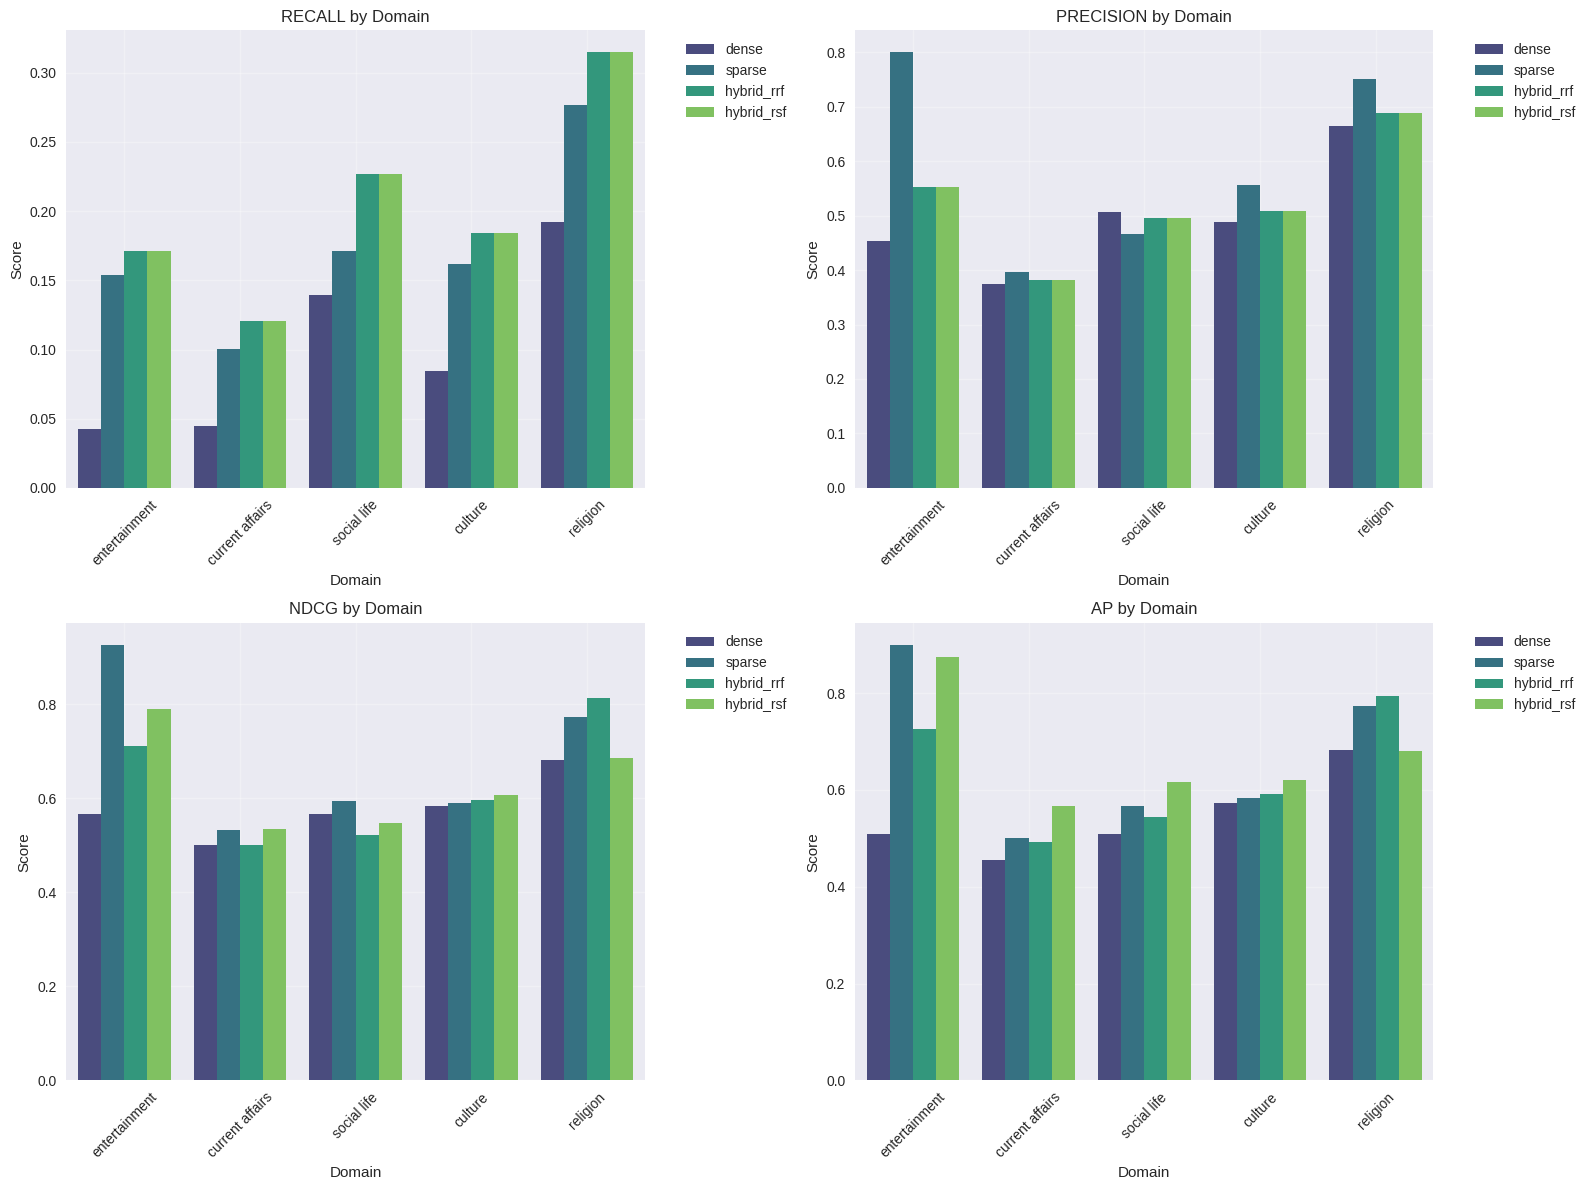

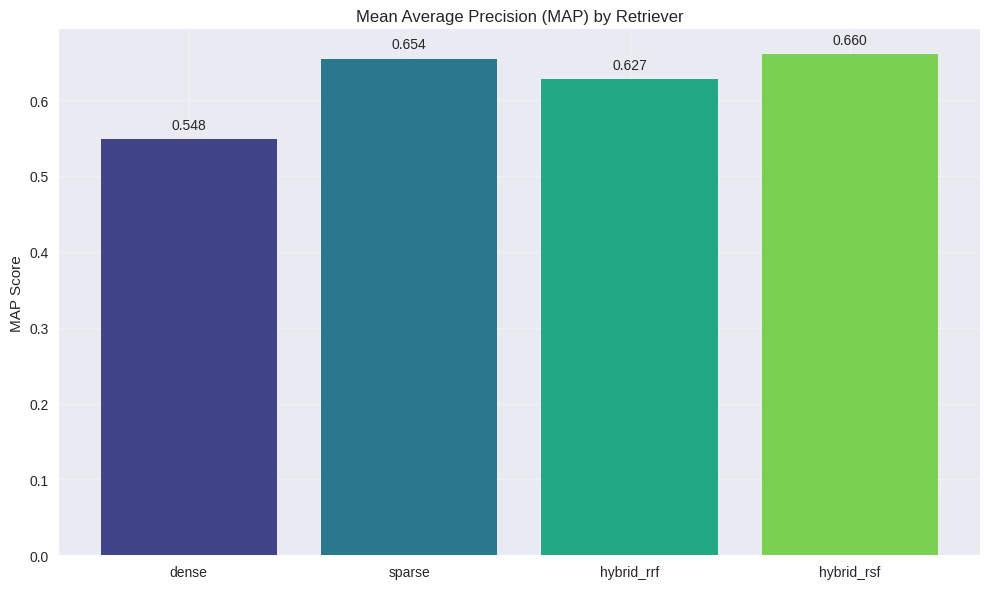

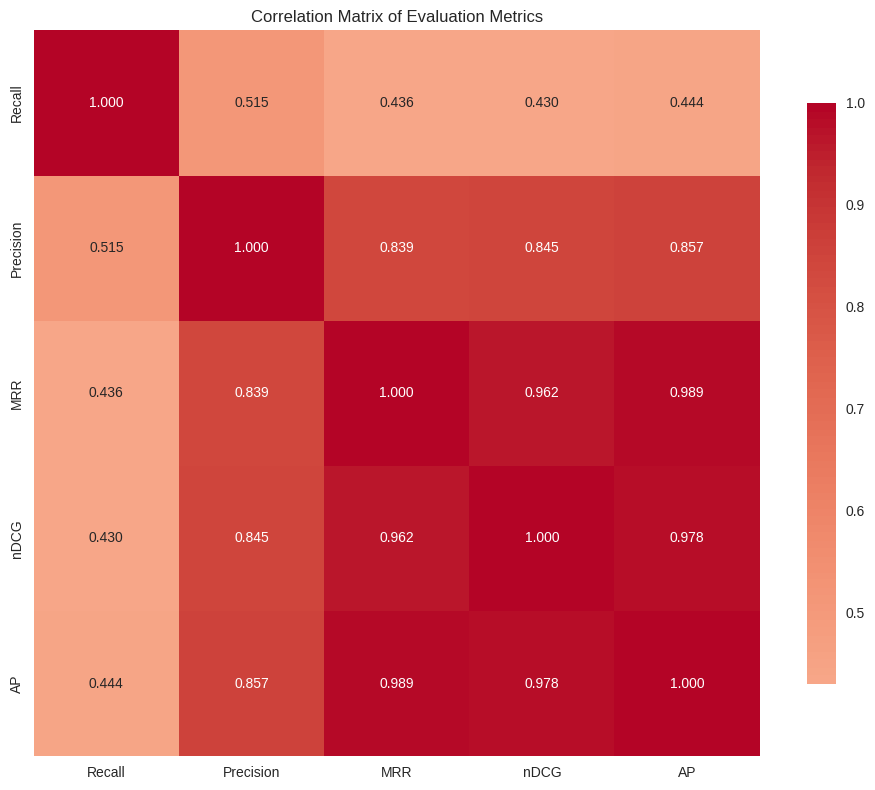

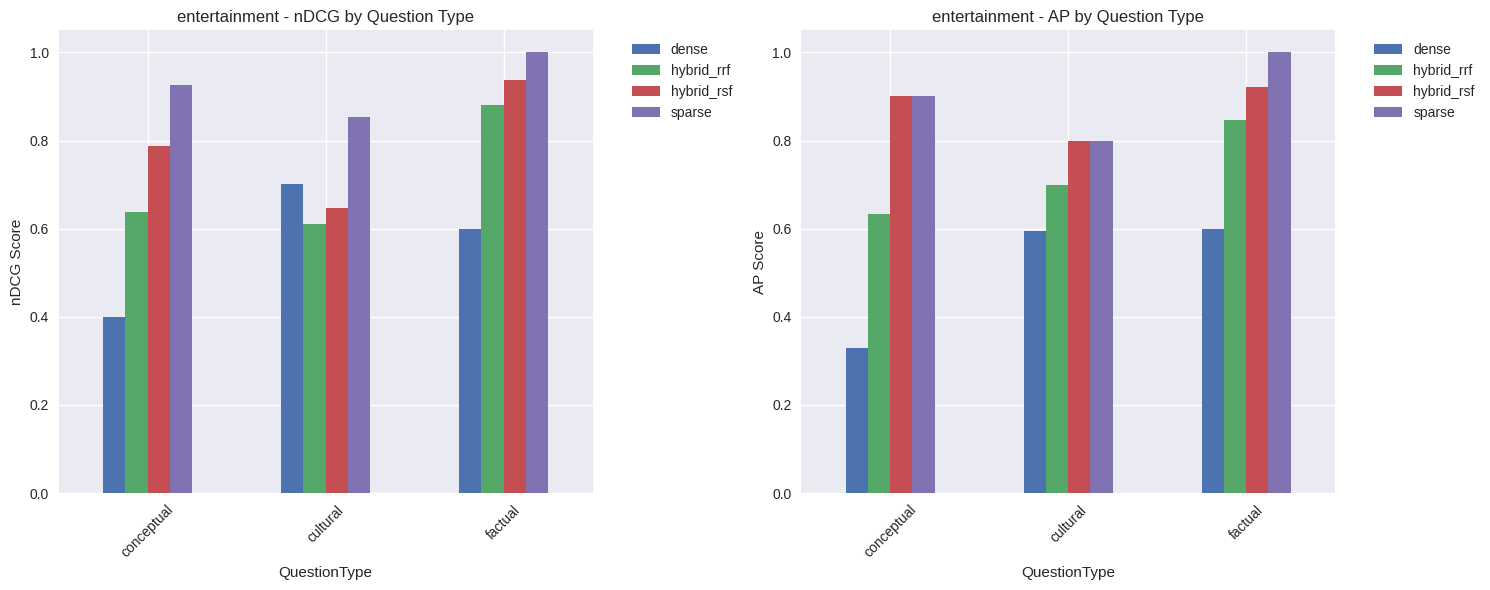

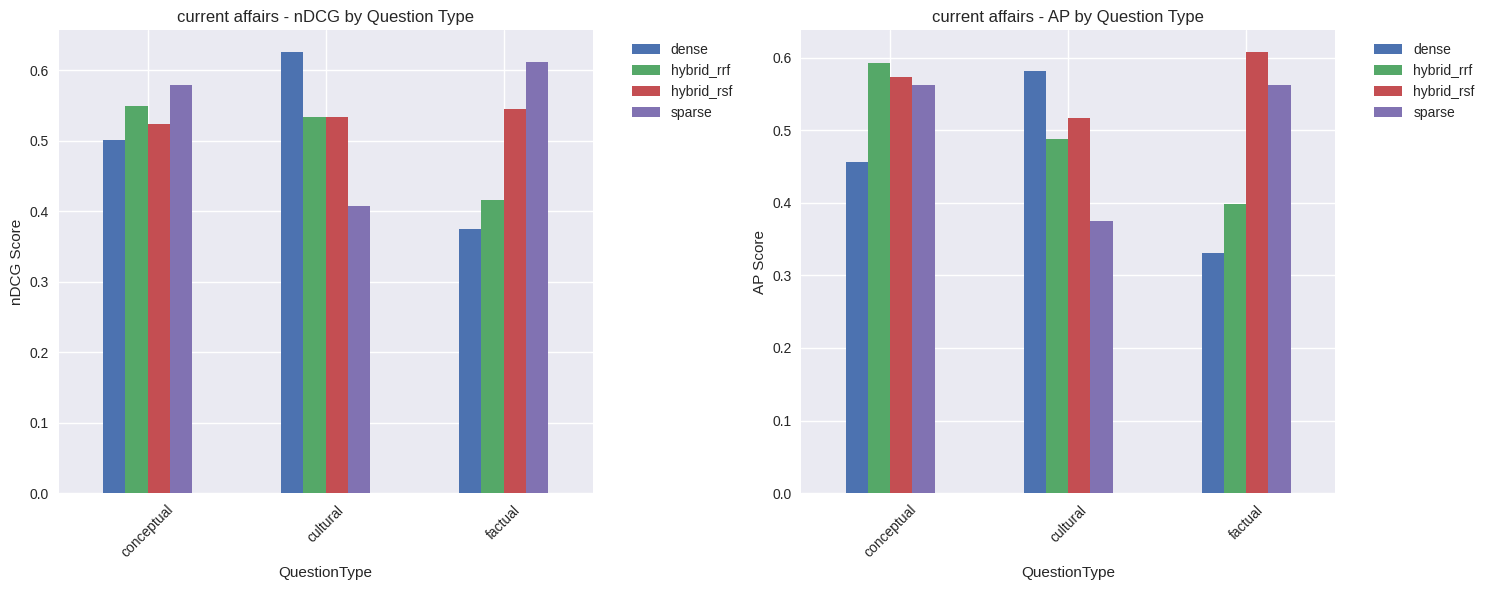

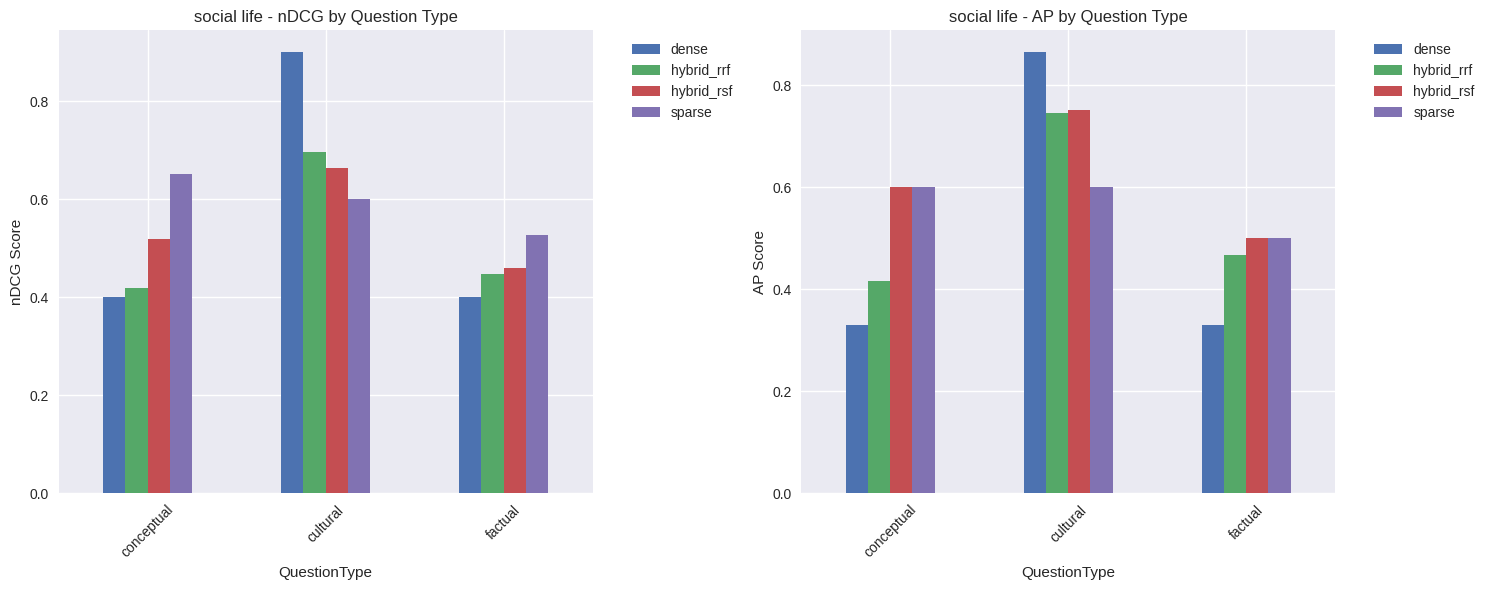

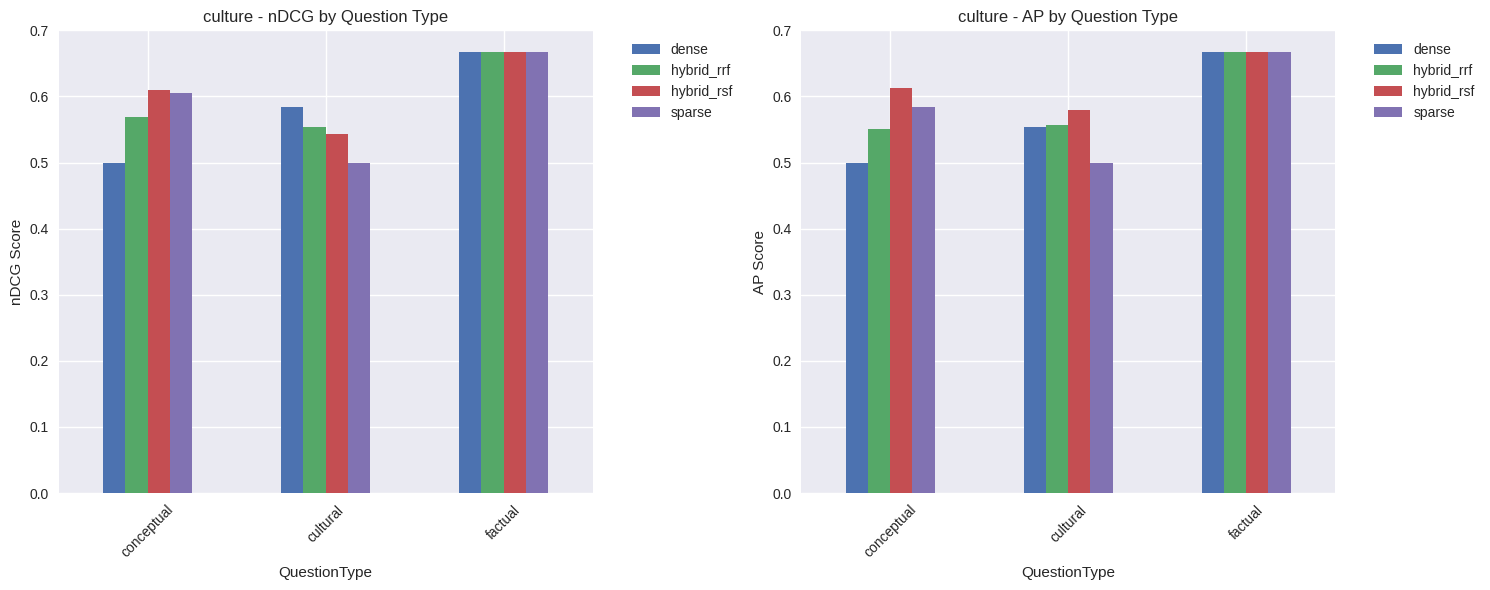

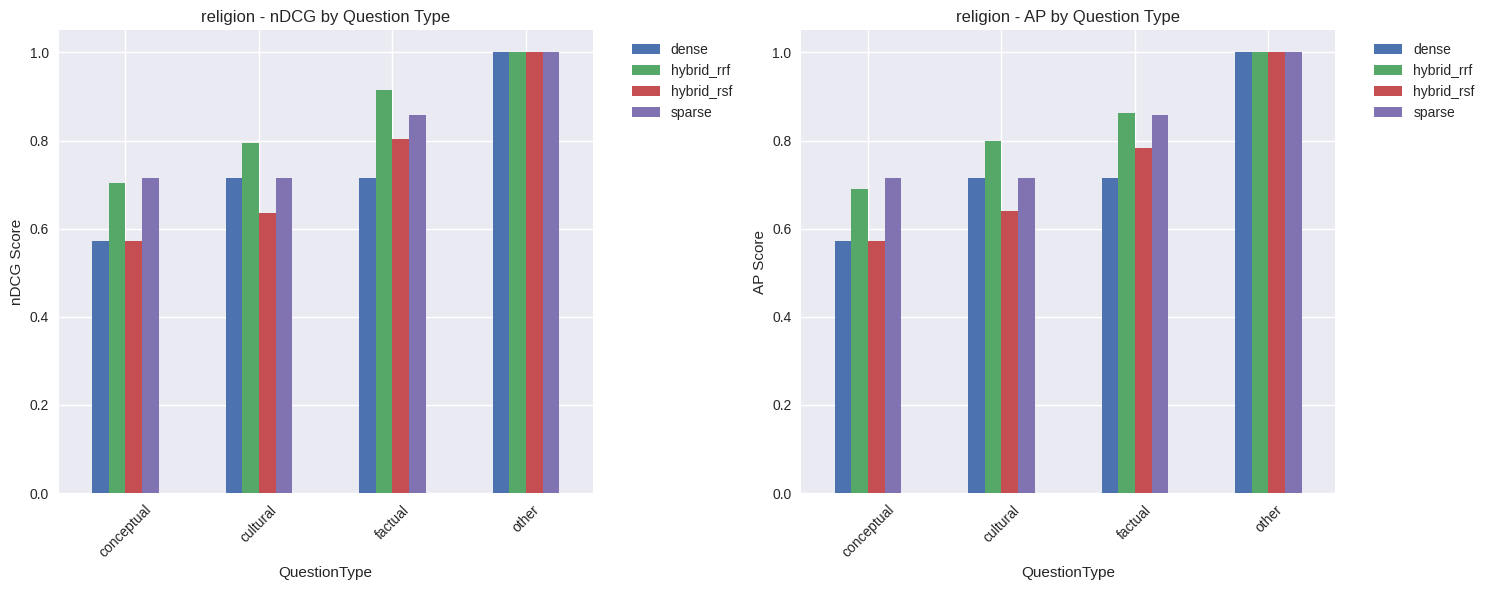

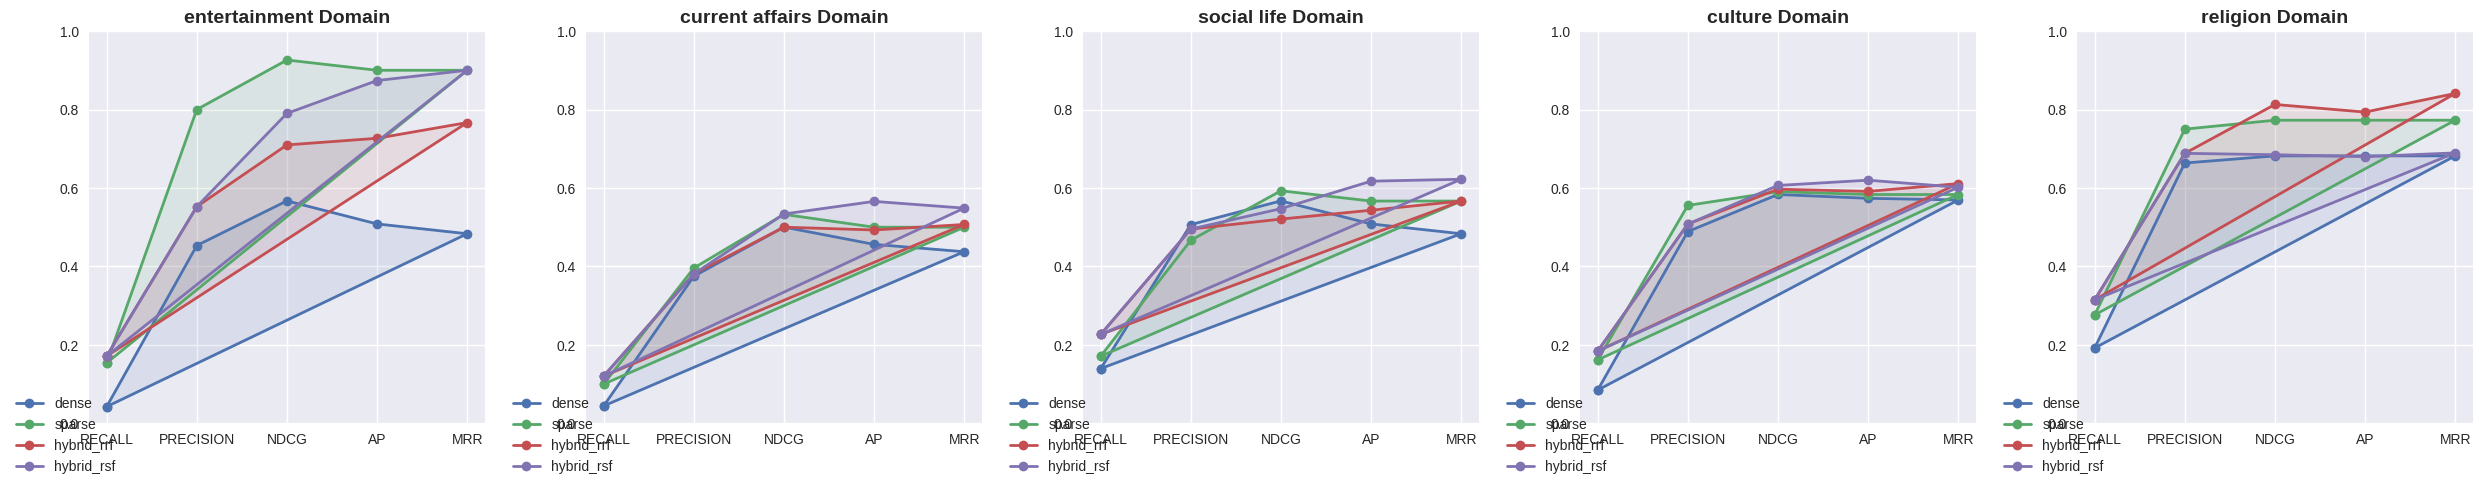

COMPREHENSIVE RETRIEVAL EVALUATION REPORT

1. OVERALL PERFORMANCE (MAP):
----------------------------------------
dense          : 0.5481
sparse         : 0.6543
hybrid_rrf     : 0.6274
hybrid_rsf     : 0.6602

Best performing retriever: hybrid_rsf (MAP: 0.6602)

2. DOMAIN-WISE PERFORMANCE:
----------------------------------------

ENTERTAINMENT DOMAIN:
  sparse          | Recall: 0.154 | Precision: 0.800 | nDCG: 0.926 | AP: 0.900
  hybrid_rsf      | Recall: 0.171 | Precision: 0.552 | nDCG: 0.790 | AP: 0.874
  hybrid_rrf      | Recall: 0.171 | Precision: 0.552 | nDCG: 0.710 | AP: 0.727
  dense           | Recall: 0.043 | Precision: 0.453 | nDCG: 0.567 | AP: 0.508

CURRENT AFFAIRS DOMAIN:
  hybrid_rsf      | Recall: 0.120 | Precision: 0.381 | nDCG: 0.534 | AP: 0.566
  sparse          | Recall: 0.100 | Precision: 0.396 | nDCG: 0.533 | AP: 0.500
  dense           | Recall: 0.044 | Precision: 0.375 | nDCG: 0.500 | AP: 0.456
  hybrid_rrf      | Recall: 0.120 | Precision: 0.381 | nDCG: 0.500

In [ ]:
# Initialize enhanced evaluator
enhanced_evaluator = EnhancedYorubaRetrievalEvaluator(ground_truth)

# Evaluate all retrievers
retrievers = {
    "dense": dense_retriever,
    "sparse": sparse_retriever,
    "hybrid_rrf": rrf_hybrid,
    "hybrid_rsf": rsf_hybrid
}

for name, retriever in retrievers.items():
    print(f"Evaluating {name}...")
    enhanced_evaluator.evaluate_retriever(retriever, name)

# Initialize visualizer
visualizer = RetrievalVisualizer(enhanced_evaluator)

# Generate all visualizations
print("Generating comprehensive visualizations...")
visualizer.plot_domain_performance()
visualizer.plot_retriever_comparison()
visualizer.plot_metric_correlation()
visualizer.plot_question_type_analysis()
visualizer.plot_performance_radar()

# Generate text report
visualizer.generate_comprehensive_report()

# Export detailed results to CSV
def export_detailed_results(evaluator, filename="yoruba_retrieval_results.csv"):
    """Export detailed results for further analysis"""
    all_data = []
    for retriever_name, queries in evaluator.query_level_results.items():
        for query in queries:
            query_data = query.copy()
            query_data['retriever'] = retriever_name
            all_data.append(query_data)

    df = pd.DataFrame(all_data)
    df.to_csv(filename, index=False, encoding='utf-8')
    print(f"Detailed results exported to {filename}")
    return df

# Export results
detailed_df = export_detailed_results(enhanced_evaluator)